# Preliminary operations

In [1]:
#@title Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow import keras
tfk = tf.keras
tfkl = tf.keras.layers

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 15.3 MB/s eta 0:00:00


In [3]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


#Data access

In [ ]:
#@title Functions needed to access data
def get1image(name='img_name'):
  ''' 
    It returns the the requested image in form of a batch of 1 element, processed as those in the model creation.
    It will be a ndarray in the shape: (1, 224, 224, 3)
    The values are in the range 0-255
  '''
  generator = ImageDataGenerator().flow_from_directory(directory = test_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = None,
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)
  idx = generator.filenames.index(name)
  
  for i in range(idx):
    batch = next(generator)
  
  batch = next(generator)
  image = batch
  #print("(Input) image shape:", image.shape)

  image_2_show = batch[0]/255
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.double(image_2_show),cmap='gray')
  return image

def get_next_batch(generator, image_index=0): #function to take one batch from generator, to take an image we consider first element of the batch
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)


  # Visualize only the first sample
  image = image[image_index]
  target = target[image_index]
  target_idx = np.argmax(target)
  
  idx = (generator.batch_index -1) * generator.batch_size
  print(generator.filenames[idx : idx + generator.batch_size][image_index])
  
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  image_2_show = image[:,:,0]
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.double(image_2_show),cmap='gray')

  return batch, image_2_show, target
'''
def get_next_image(generator):
  batch = next(generator)
  image = batch
  idx = generator.batch_index-1
  name = generator.filenames[idx]
  label = generator.labels[idx]
  #image_2_show = batch[0]/255
  #fig = plt.figure(figsize=(6, 4))
  #plt.imshow(np.double(image_2_show),cmap='gray')
  return image, name, label, idx
'''

def get_next_image(generator):
  #restituisce un immagine su tre canali, i pixel sono nel range 0-1
  im = next(generator)
  im = im[0]
  im = im[0,:,:,:]#/np.amax(im)
  return im

def visualize_images(batch):
  # generator.next() provides [images, labels] (with dimension batch_size)

  images = batch[0]
  dim = images.shape
  dim = dim[0]
  size,scale = 224, 10
  c=8
    
  for i in range(int(dim/c)):
    f, axs = plt.subplots(1,c, figsize=(20,20))
    axs.flat
    xs = images[i*c:i*c+c]
    for j in range(c):
      img = xs[j]
      axs[j].imshow(img/255)
      


# Create a generator that can apply to images two kind of noise but also no noise at all:
- Salt & Pepper
- Gaussian
- Nothing

In [ ]:
#@title Invert images when needed
def get_bg_angle(bkgr, angle):
  for _, row in enumerate(angle):
    for _, pix in enumerate(row):
      if pix<255*0.2:
        bkgr.append(0)
      elif pix>255*0.8:
        bkgr.append(1)
  return bkgr

def is_inverted(im):
  #input is a 224x224 image on 3 channels (224,224,3)
  #pixels should range in 0-255
  top_left = im[0:5,0:5]
  top_right = im[0:5,-5:225]
  bottom_left = im[-5:225, 0:5]
  bottom_right = im[-5:225,-5:225]

  background = []
  for _,ang in enumerate([top_left, top_right, bottom_left, bottom_right]):
    background = get_bg_angle(background, ang)

  if sum(background) < 0.5*len(background):
    inv = 0
  else: 
    inv = 1
  return inv

def invert(im):
  if is_inverted(im):
    return 255-im
  else:
    return im

In [ ]:
#@title Noise functions

def add_noise(im, noise_amount = 0.3):
  noise_factor = noise_amount*255
  noise_vector = np.random.normal(loc=0.0, scale=1.0, size=im.shape[0]*im.shape[1])
  noise_matrix = np.reshape(noise_vector , newshape= (im.shape[0],im.shape[1]))
  im_n = im[:,:] + noise_factor * noise_matrix
  for i, row in enumerate(im_n):
    for j, pix in enumerate(row):
      if pix<0:
        im_n[i,j]=0
      elif pix>255:
        im_n[i,j]=255

  return im_n

def add_reversion(im):
    '''Black pixels become white and vice versa'''
    im_n = im[:,:]
    im_n = 255 - im_n
    return im_n

def add_salt_pepper(im, noise_amount=0.1):
    '''Add salt and pepper noise to image'''
    
    # make a copy of the image
    im_n = im[:,:]

    # the threshold for the random number to be less than or greater than
    rdn_threshold = noise_amount

    # for each pixel in the image, there is a noise_amount chance that it will be replaced with 0 or 255
    for i, row in enumerate(im_n):
        # for each pixel in the row
        for j, pix in enumerate(row):
            # i is the row index, j is the column index
            rdn = np.random.normal(loc=0.5, scale = 0.1)
            
            if rdn < rdn_threshold:
                im_n[i,j] = 0
            elif rdn > 1-rdn_threshold:
                im_n[i,j] = 255
    return im_n

In [ ]:
#@title make_image_noisy()
'''def make_image_noisy(im):
  '''
'''This function randomly applies one of the three noise functions
  Input: image
  Output: noisy image'''
'''
  switch = np.random.randint(0,4)
  # 0: no noise
  if switch==1:
    # 1: reversion
    im=add_reversion(im)
  elif switch==2:
    # 2: salt and pepper
    im=add_salt_pepper(im, 0.3)
  elif switch==3:
    # 3: Gaussian
    im=add_noise(im, 0.2)

  return im'''

#Tolgo l'inversione dalla funzione, perché quella è risolta senza bisogno di una rete, semplicemente con l'algoritmo nella funzione sotto.

def make_image_noisy(image):
  '''
  This function randomly applies one of the three noise functions
  Input: image
  Output: noisy image
  '''
  image = invert(image)
  switch = np.random.randint(1,3)
  # 0: no noise
  if switch==1:
    # 1: salt and pepper
    image=add_salt_pepper(image, 0.32)
  elif switch==2:
    # 2: Gaussian
    image=add_noise(image, 0.3)
  return image

In [ ]:
#@title Data parameters

height = 224 #@param
width  = 224 #@param

data_hyperparameters = {
    'batch_size': 32,
    'resized_shape_height': height,
    'resized_shape_width': width,
    'color_mode': 'grayscale'
}

n_channels = 1 if data_hyperparameters['color_mode']=='grayscale' else 3
input_shape = (data_hyperparameters['resized_shape_height'],data_hyperparameters['resized_shape_width'],n_channels) 

In [ ]:
train_dir       = '/content/gdrive/MyDrive/Assignment/Clean_And_Preprocessed_Dataset/CLEAN/TRAIN'
validation_dir  = '/content/gdrive/MyDrive/Assignment/Clean_And_Preprocessed_Dataset/CLEAN/VAL'

train_datagen=ImageDataGenerator()
train_set = train_datagen.flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'input',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False, 
                                                                seed = seed)

validation_datagen=ImageDataGenerator()
validation_set = validation_datagen.flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'input',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False, 
                                                                seed = seed)


images_path_train       = [train_dir      + '/' + s for s in train_set.filenames]
images_path_validation  = [validation_dir + '/' + s for s in validation_set.filenames]

Found 9558 images belonging to 3 classes.
Found 1058 images belonging to 3 classes.


In [ ]:
class DG_autoencoder(keras.utils.Sequence):
    """
    A data generator that yields batches of noisy and clean images for training an autoencoder.
    The generator reads the images from the file paths and adds uniform noise to them.
    Parameters
    ----------
    batch_size : int
        The number of images in each batch.
    img_size : tuple
        The size to which the images should be resized.
    input_paths : list
        A list of file paths to the input images.
    target : list
        A list of labels corresponding to the input images.
    """

    def __init__(self, batch_size, img_size, input_paths, target):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_paths
        self.target = target
        self.directory = 'dataset/'
        self.channels = 1

    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]

        x_noisy = np.zeros((self.batch_size,) + self.img_size + (self.channels,))
        x = np.zeros((self.batch_size,) + self.img_size + (self.channels,))

        for j, path in enumerate(batch_input_img_paths):
            orig_imag = cv2.imread(path, 0)  # read as grayscale
            resized_imag = cv2.resize(orig_imag, self.img_size, interpolation=cv2.INTER_CUBIC)
            imag = resized_imag.astype('float32')
            x_noisy[j] = np.expand_dims(make_image_noisy(imag), 2)
            x[j] = np.expand_dims(resized_imag, 2)

        x_noisy = x_noisy/255
        x = x/255

        return x_noisy, x

    def __len__(self):
        return len(self.target) // self.batch_size

In [ ]:
dg_train = DG_autoencoder(data_hyperparameters['batch_size'], (input_shape[0],input_shape[1]), images_path_train, images_path_train)

dg_validation = DG_autoencoder(data_hyperparameters['batch_size'], (input_shape[0],input_shape[1]), images_path_validation, images_path_validation)

In [ ]:
def show_noisy_images(generator, batch_index=0, batch_size=32):
    batch = generator[batch_index]
    images_noisy = batch[0] # this is the x
    images_clean = batch[1] # this is the y

    # showing all the images in the batch
    for i in range(batch_size):
        plt.figure(figsize=(10,20))
        plt.subplot(batch_size,2,i*2+1)
        plt.imshow(images_noisy[i,:,:,0], cmap='gray')
            
        plt.subplot(batch_size,2,i*2+2)
        plt.imshow(images_clean[i,:,:,0], cmap='gray')

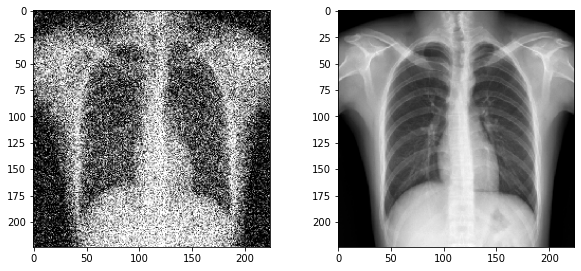

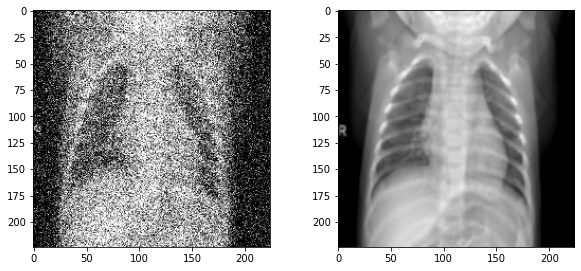

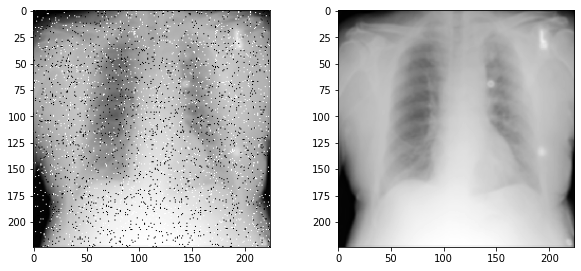

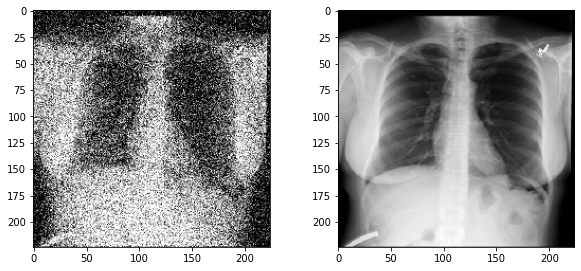

In [ ]:
show_noisy_images(dg_train, 0, 4)

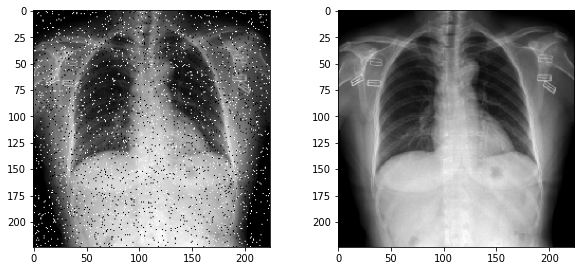

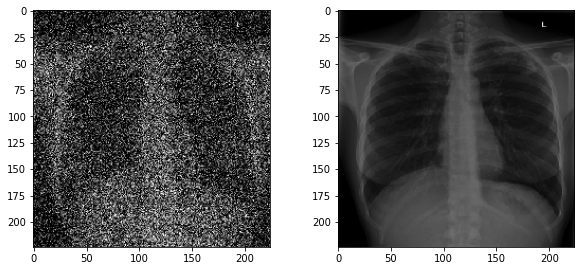

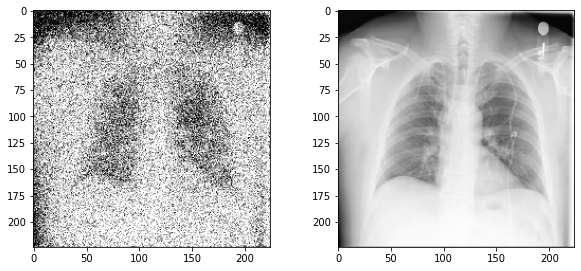

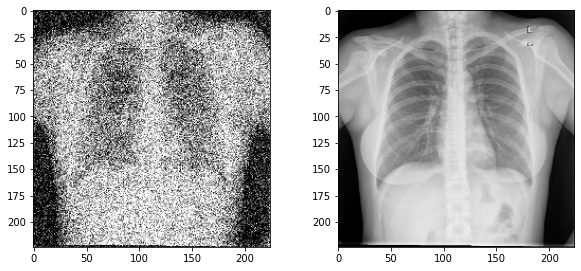

In [ ]:
show_noisy_images(dg_validation, 0, 4)

# Denoising Autoencoder

In [ ]:
def get_autoencoder(input_shape):
    # Input shape 224x224x1
    input_img = tfkl.Input(input_shape)

    # Conv1
    x = tfkl.Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(input_img) # 224x224x1

    # Conv2
    x = tfkl.Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(x) # 224x224x1

    # Conv3
    x = tfkl.Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(x) # 224x224x1

    # Conv4
    x = tfkl.Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(x) # 224x224x1

    decoded = tfkl.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x) # 224x224x1

    # Declare the model
    autoencoder = tfk.Model(input_img, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 1)       10        
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 1)       10        
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 1)       10        
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 1)       10        
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 1)       2         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0

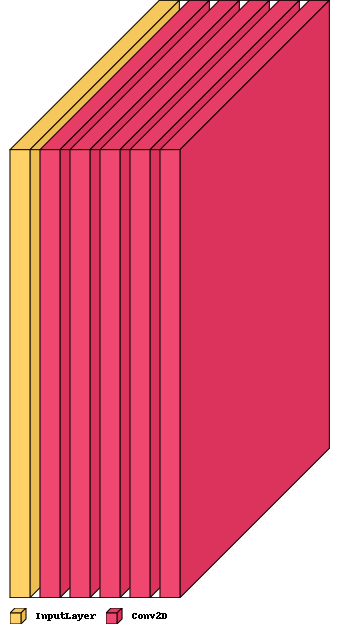

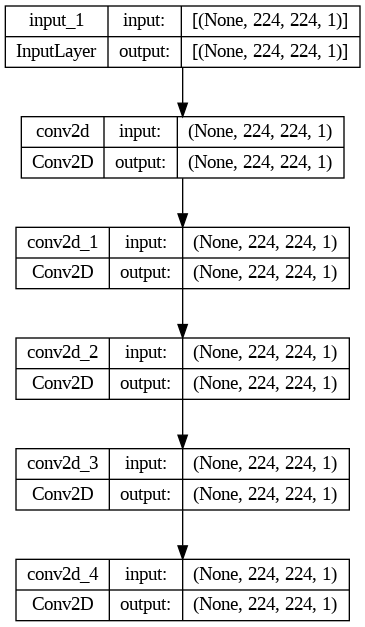

In [ ]:
#@title Building Auto-Encoder

autoencoder = get_autoencoder(input_shape)
autoencoder.summary()
display(visualkeras.layered_view(autoencoder, legend=True, scale_xy=2))
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True)

In [ ]:
epochs = 8
patience = 10

In [ ]:
#callbacks
from datetime import datetime
def create_folders_and_callbacks(model_name, ES_patience = 5):
    
    exps_dir = os.path.join('/content/gdrive/MyDrive/Assignment/Denoising_Autoencoder/Archive',model_name)

    print("Model will be saved in: " + str(exps_dir))
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= ES_patience, restore_best_weights=True)
    callbacks.append(es_callback)

    # Reduce On Plateau
    # --------------
    RonPlateau_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    callbacks.append(RonPlateau_callback)
    
    return callbacks


In [ ]:
autoencoder_callbacks = create_folders_and_callbacks(model_name='only_conv_4_layer_autoencoder', ES_patience = patience)

Model will be saved in: /content/gdrive/MyDrive/Assignment/Denoising_Autoencoder/Archive/only_conv_4_layer_autoencoder


In [ ]:
#@title If need to restore from last checkpoint do it here:

# Restore the model from the latest checkpoint

latest = tf.train.latest_checkpoint("/content/gdrive/MyDrive/Assignment/Denoising_Autoencoder/Archive/only_conv_4_layer_autoencoder/only_conv_4_layer_autoencoder_Jan30_10-39-16/ckpts")
print(latest)

answer = input('Do you wish to load last checkpoint ? (Y/N) ')

if answer=='Y':
  # Use the restored model and evaluate performances
  print('Loading checkpoint')
  autoencoder.load_weights(latest)
  #print("These were last time performances: ") 
  #[val_loss ] = autoencoder.evaluate(dg_validation)
else:
    print('I will not reload since last checkpoint')

/content/gdrive/MyDrive/Assignment/Denoising_Autoencoder/Archive/only_conv_4_layer_autoencoder/only_conv_4_layer_autoencoder_Jan30_10-39-16/ckpts/cp.ckpt
Do you wish to load last checkpoint ? (Y/N) Y
Loading checkpoint


In [ ]:
history = autoencoder.fit(dg_train,
    batch_size=32,
    epochs=epochs,
    validation_data=dg_validation,
    callbacks = autoencoder_callbacks
).history

Epoch 1/8
298/298 [==============================] - 1026s 3s/step - loss: 0.0117 - val_loss: 0.0124 - lr: 0.0010
Epoch 2/8
298/298 [==============================] - 971s 3s/step - loss: 0.0113 - val_loss: 0.0121 - lr: 0.0010
Epoch 3/8
157/298 [==============>...............] - ETA: 6:49 - loss: 0.0116

In [ ]:
original_image = dg_validation[0][1][5][:,:,0]

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(original_image, cmap='gray')

In [ ]:
image_to_clean = dg_validation[0][0][5][:,:,0]

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(image_to_clean, cmap='gray')

In [ ]:
def expand_image(image):
    input = np.array([image])
    resized_input = tf.expand_dims(input, axis=-1)
    return resized_input

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(image_to_clean,cmap='gray')

In [ ]:
image_expanded = expand_image(image_to_clean)

In [ ]:
image_cleaned_expanded = autoencoder.predict(image_expanded)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(image_cleaned_expanded[0,:,:,0], cmap='gray')

In [ ]:
autoencoder.save('autoencoder_latent2')